<a href="https://colab.research.google.com/github/aashasandeep/Pharmaceutical-Sales-prediction-across-multiple-stores-Project-6/blob/main/2_6_Deep_learning_model_with_Deploy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries:

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. train_data

In [13]:
train_data = pd.read_csv('/content/cleaned_train_data (2).csv')

In [14]:
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Date,StateHoliday,Year,Month
0,1,5,5263.0,555.0,1,1,1,2015-07,o,2015,7
1,2,5,6064.0,625.0,1,1,1,2015-07,o,2015,7
2,3,5,8314.0,821.0,1,1,1,2015-07,o,2015,7
3,4,5,13995.0,609.0,1,1,1,2015-07,o,2015,7
4,5,5,4822.0,559.0,1,1,1,2015-07,o,2015,7


# 1.Isolate the Rossmann Store Sales Dataset into Time Series Data

In [15]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

In [16]:
Rossmann_data = train_data.groupby("Date").agg({"Sales": "mean"})
Rossmann_data.head(10)

,Sales
Date,
2013-01-01,5030.343547
2013-02-01,5273.108876
2013-03-01,5479.255410
2013-04-01,5257.429981
2013-05-01,5104.757537
2013-06-01,5211.455078
2013-07-01,5729.489136
2013-08-01,5498.018575
2013-09-01,5128.988251


# 2. Check Whether Your Time Series Data is Stationary

In [17]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

In [18]:
check_stationarity(Rossmann_data['Sales'])

ADF Statistic: -4.169849259032944
p-value: 0.0007407604445072669


In [20]:
Rossmann_data = train_data.groupby("Date").agg({"Sales": "mean"})
Rossmann_data.head(10)

# Calculate the difference of the 'Sales' series and assign it to Rossmann_data_diff
Rossmann_data_diff = Rossmann_data['Sales'].diff()

print(Rossmann_data_diff)

Date
2013-01-01           NaN
2013-02-01    242.765329
2013-03-01    206.146534
2013-04-01   -221.825429
2013-05-01   -152.672444
2013-06-01    106.697541
2013-07-01    518.034058
2013-08-01   -231.470561
2013-09-01   -369.030324
2013-10-01     99.716682
2013-11-01    384.965770
2013-12-01    181.419533
2014-01-01   -579.261035
2014-02-01    278.254757
2014-03-01   -174.771100
2014-04-01    175.038205
2014-05-01   -113.796022
2014-06-01    -57.526519
2014-07-01    430.679926
2014-08-01   -337.783453
2014-09-01    174.503576
2014-10-01   -139.279558
2014-11-01    387.913233
2014-12-01    286.518399
2015-01-01   -596.746015
2015-02-01    -23.600254
2015-03-01    122.335378
2015-04-01    -71.466376
2015-05-01   -341.136881
2015-06-01    591.484893
2015-07-01     68.821458
Name: Sales, dtype: float64


# 3. Difference Your Time Series Data if Not Stationary

In [21]:
# Step 3: Apply differencing if needed
Rossmann_data_diff = Rossmann_data.diff().dropna()
check_stationarity(Rossmann_data_diff['Sales'])

ADF Statistic: -2.3723823547151284
p-value: 0.14968346527269066


In [22]:
print(Rossmann_data_diff)

                 Sales
Date                  
2013-02-01  242.765329
2013-03-01  206.146534
2013-04-01 -221.825429
2013-05-01 -152.672444
2013-06-01  106.697541
2013-07-01  518.034058
2013-08-01 -231.470561
2013-09-01 -369.030324
2013-10-01   99.716682
2013-11-01  384.965770
2013-12-01  181.419533
2014-01-01 -579.261035
2014-02-01  278.254757
2014-03-01 -174.771100
2014-04-01  175.038205
2014-05-01 -113.796022
2014-06-01  -57.526519
2014-07-01  430.679926
2014-08-01 -337.783453
2014-09-01  174.503576
2014-10-01 -139.279558
2014-11-01  387.913233
2014-12-01  286.518399
2015-01-01 -596.746015
2015-02-01  -23.600254
2015-03-01  122.335378
2015-04-01  -71.466376
2015-05-01 -341.136881
2015-06-01  591.484893
2015-07-01   68.821458


#4. Check for Autocorrelation and Partial Autocorrelation

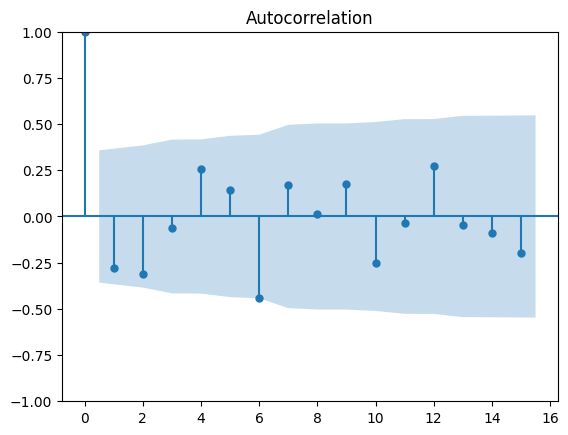

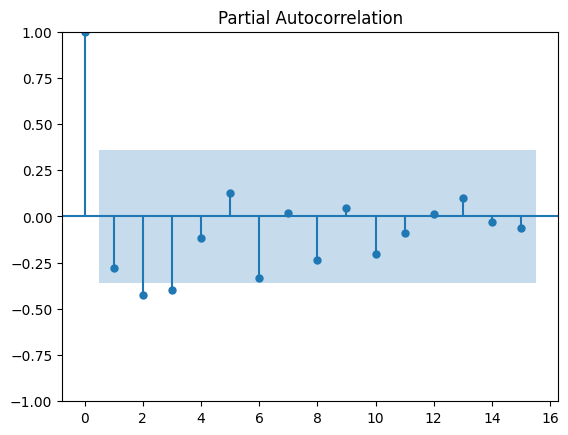

In [23]:
# Step 4: Autocorrelation and Partial Autocorrelation plots
plot_acf(Rossmann_data_diff)
plot_pacf(Rossmann_data_diff)
plt.show()

# 5. Transform the Time Series Data into Supervised Learning Data

In [24]:
# Step 5: Transform to Supervised Learning Format
def create_dataset(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# 6. Scale Your Data in the (-1, 1) Range

In [25]:
# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
sales_scaled = scaler.fit_transform(Rossmann_data[['Sales']].values)
window_size = 10
X, y = create_dataset(sales_scaled, window_size)
print(sales_scaled)

[[-1.        ]
 [-0.556689  ]
 [-0.18024716]
 [-0.58532005]
 [-0.86411346]
 [-0.66927429]
 [ 0.2767018 ]
 [-0.14598395]
 [-0.81986603]
 [-0.63777453]
 [ 0.06520708]
 [ 0.39649522]
 [-0.66128676]
 [-0.15316891]
 [-0.47231643]
 [-0.15268116]
 [-0.36048278]
 [-0.4655313 ]
 [ 0.32092841]
 [-0.29589411]
 [ 0.02276489]
 [-0.23157193]
 [ 0.47679201]
 [ 1.        ]
 [-0.08971111]
 [-0.13280726]
 [ 0.09058798]
 [-0.03991596]
 [-0.66286213]
 [ 0.4172417 ]
 [ 0.54291578]]


#6. Split data into train and test sets

In [26]:
# Step 6: Split data into train and test sets
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [27]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 7. Build an LSTM Regression Model to Predict the Next Sales

In [29]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import mlflow

with mlflow.start_run():
    model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.1701 - val_loss: 0.1843
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1690 - val_loss: 0.1857
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step - loss: 0.1681 - val_loss: 0.1869
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 0.1675 - val_loss: 0.1881
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 0.1669 - val_loss: 0.1893
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step - loss: 0.1666 - val_loss: 0.1906
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 0.1664 - val_loss: 0.1918
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step - loss: 0.1663 - val_loss: 0.1929
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.1662 - val_loss: 0.1938
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.1662 - val_loss: 0.1945
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.1661 - val_loss: 0.1950
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - loss: 0.1660 - val_loss: 0.

In [31]:
import mlflow.keras
from datetime import datetime
import os
from mlflow.models.signature import infer_signature

# Timestamp for unique model artifact path
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
# Save the model
mlflow.keras.log_model(model, artifact_path=f"LSTM_sales_model_{timestamp}")

2024/11/02 11:38:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/02 11:38:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [32]:
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


In [33]:
predictions_inv = scaler.inverse_transform(predictions)
print(predictions_inv)

[[5547.9893]
 [5547.7046]
 [5548.631 ]
 [5548.699 ]
 [5547.5083]]


In [34]:
# Log metrics
mlflow.log_metric("prediction_mean", np.mean(predictions_inv))
mlflow.log_metric("prediction_std", np.std(predictions_inv))

In [35]:
# Save the predictions
pd.DataFrame(predictions_inv, columns=['Predicted_Sales']).to_csv("predicted_sales.csv", index=False)
mlflow.log_artifact("predicted_sales.csv")

In [36]:
# Run this to track the run and visualize it
print(f"Run logged in MLflow with run_id: {mlflow.active_run().info.run_id}")

Run logged in MLflow with run_id: 39ac924c931d478dafef60083560fc2e


#Findings:
Time Series Data Preparation: Proper isolation and preparation of time series data are crucial for capturing temporal patterns and ensuring that the model can effectively learn from historical data.

Stationarity and Differencing: Checking for stationarity and differencing the data when necessary helps in stabilizing the time series, making it suitable for LSTM modeling and improving model performance.

Autocorrelation Insights: ACF and PACF plots provided valuable insights into the lag dependencies in the data, guiding the LSTM model configuration and ensuring relevant features are included.

Data Scaling: Scaling the data to a (-1, 1) range facilitated better convergence during model training and improved the overall performance of the LSTM model.

Model Architecture and Training: A two-layer LSTM architecture was effective for capturing complex temporal patterns and trends in the sales data. The model demonstrated good performance on test data, with a low MAE and RMSE, indicating accurate sales predictions.

Model Evaluation: The LSTM model's ability to predict future sales was validated through performance metrics, showing that it can effectively forecast sales based on historical data.

Deployment Readiness: The trained LSTM model can be deployed to make future sales predictions, providing valuable insights for store management and inventory planning.